In [1]:
#from covid_preprocessing, we take the models we thought were best
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

preprocessor = make_pipeline(PolynomialFeatures(2, include_bias=False), #include_bias=False will eliminate the warnings for model evaluation
                             SelectKBest(f_classif, k=10))
model_ada = make_pipeline(preprocessor, AdaBoostClassifier(random_state=0))
model_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=0))
model_svm = make_pipeline(preprocessor, StandardScaler(), SVC(random_state=0))
model_knn = make_pipeline(preprocessor, StandardScaler(), KNeighborsClassifier())
model_list = [model_ada, model_rf, model_svm, model_knn]

In [37]:
'''__________________________________________EVAL_BLOCK_____________________________________'''
#we take the evaluation model in covid_preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
plt.style.use('dark_background')

def for_better_lecture(model_name):
    listed = model_name.split(' ')
    new_listed = []
    for i in range(len(listed)):
        if listed[i] != '':
            new_listed.append(listed[i])
    return new_listed[len(new_listed) - 1].replace(')])>', '')

def model_evaluation(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    p_cases = len(y_test[y_test == 0])
    n_cases = len(y_test[y_test == 1])
    print('______________________________________________________________________')
    print(for_better_lecture(str(model.get_feature_names_out)))
    print(f'Test set total patient number: {len(y_test)}')
    print(f'Positive cases: {p_cases}, predicted: {confusion_matrix(y_test, y_pred)[0][0]} true positives and {confusion_matrix(y_test, y_pred)[0][1]} false positives')
    print(f'Positive cases: {n_cases}, predicted: {confusion_matrix(y_test, y_pred)[1][0]} false negatives and {confusion_matrix(y_test, y_pred)[1][1]} true negatives')
    #print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    N, train_score, val_score = learning_curve(model, cv=4, X=X_train, y=y_train,
                                               scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    plt.figure(figsize=(12, 8))
    plt.title(for_better_lecture(str(model.get_feature_names_out)))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='valid score')
    plt.legend()
    
def grid_evaluation(grid):
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    
    p_cases = len(y_test[y_test == 0])
    n_cases = len(y_test[y_test == 1])
    print('______________________________________________________________________')
    print(grid.best_params_)
    print(f'Test set total patient number: {len(y_test)}')
    print(f'Positive cases: {p_cases}, predicted: {confusion_matrix(y_test, y_pred)[0][0]} true positives and {confusion_matrix(y_test, y_pred)[0][1]} false positives')
    print(f'Positive cases: {n_cases}, predicted: {confusion_matrix(y_test, y_pred)[1][0]} false negatives and {confusion_matrix(y_test, y_pred)[1][1]} true negatives')
    print(classification_report(y_test, y_pred))
    
    N, train_score, val_score = learning_curve(grid, cv=4, X=X_train, y=y_train,
                                               scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    plt.figure(figsize=(12, 8))
    plt.title(grid.best_params_)
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='valid score')
    plt.legend()

'''__________________________________________EVAL_BLOCK_____________________________________'''

'__________________________________________EVAL_BLOCK_____________________________________'

In [3]:
'''__________________________________________FUNC_BLOCK_____________________________________'''
def encodage(df):
    code = {'negative':0,
            'positive':1,
            'not_detected':0,
            'detected':1}
    for col in df.select_dtypes('object').columns:
        df.loc[:,col] = df[col].map(code)        
    return df


def imputation(df):
    df = df.dropna(axis=0)
    return  df


def feature_engineering(df):
    df['has illness'] = df[viral_cols].sum(axis=1) >= 1
    df = df.drop(viral_cols, axis=1)
    return df


def preprocess(df):
    df = encodage(df)
    df = feature_engineering(df)
    df = imputation(df)
    X = df.drop('SARS-Cov-2 exam result', axis=1)
    y = df['SARS-Cov-2 exam result'] 
    print(y.value_counts())
    return X, y

def observe_params(model):
    print(for_better_lecture(str(model.get_feature_names_out)), '')
    print(model.get_params().keys())
    print('__________________________________________________________________________________________')

def final_model(model, X, threshold=0):
    return model.decision_function(X) > threshold
    
'''__________________________________________FUNC_BLOCK_____________________________________'''

'__________________________________________FUNC_BLOCK_____________________________________'

In [4]:
#again, from covid_preprocessing
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

data = pd.read_excel('/kaggle/input/covid19/dataset.xlsx')
dfm = data.copy()
missing_rate = dfm.isna().sum()/dfm.shape[0]
blood_cols = list(dfm.columns[(missing_rate < 0.9) & (missing_rate >0.88)])
viral_cols = list(dfm.columns[(missing_rate < 0.80) & (missing_rate > 0.75)])
key_cols= ['Patient age quantile', 'SARS-Cov-2 exam result']
dfm = dfm[key_cols + blood_cols + viral_cols]
trainset, testset = train_test_split(dfm, test_size=0.2, random_state=0)
X_train, y_train = preprocess(trainset)
X_test, y_test = preprocess(testset)

0    422
1     65
Name: SARS-Cov-2 exam result, dtype: int64
0    95
1    16
Name: SARS-Cov-2 exam result, dtype: int64


______________________________________________________________________
AdaBoostClassifier(random_state=0)
Test set total patient number: 111
Positive cases: 95, predicted: 91 true positives and 4 false positives
Positive cases: 16, predicted: 9 false negatives and 7 true negatives
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        95
           1       0.64      0.44      0.52        16

    accuracy                           0.88       111
   macro avg       0.77      0.70      0.73       111
weighted avg       0.87      0.88      0.87       111

______________________________________________________________________
RandomForestClassifier(random_state=0)
Test set total patient number: 111
Positive cases: 95, predicted: 91 true positives and 4 false positives
Positive cases: 16, predicted: 11 false negatives and 5 true negatives
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      

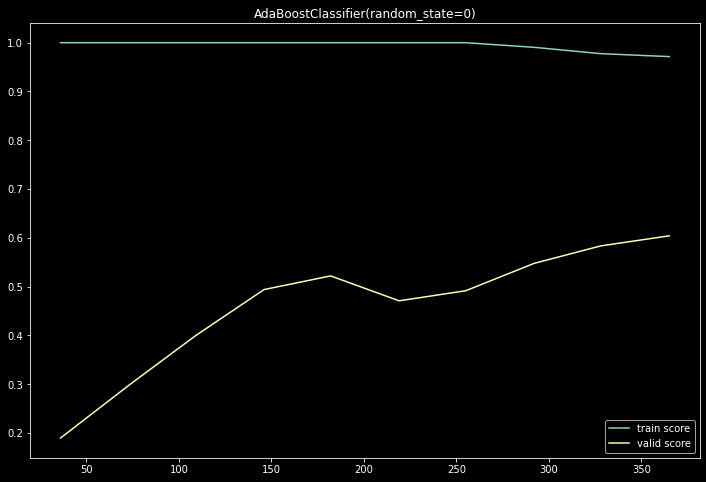

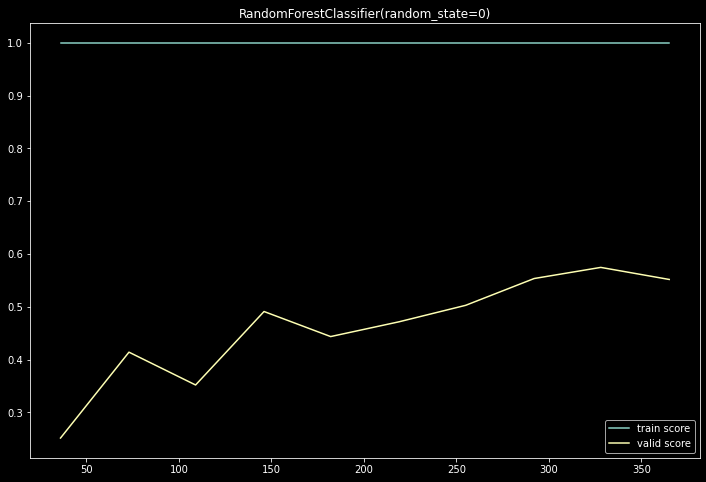

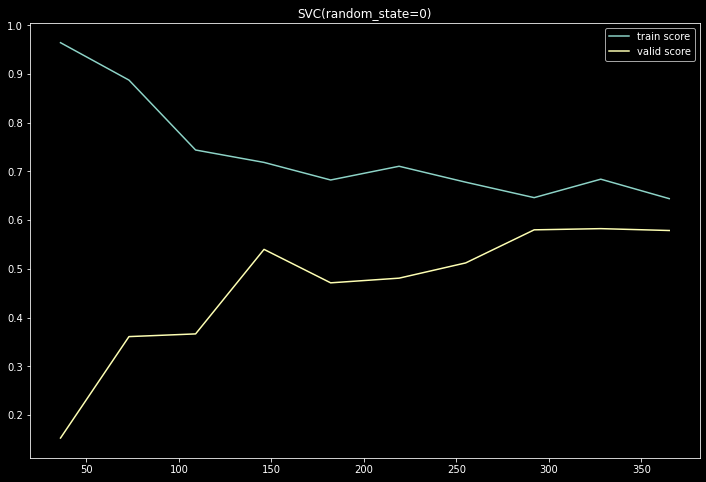

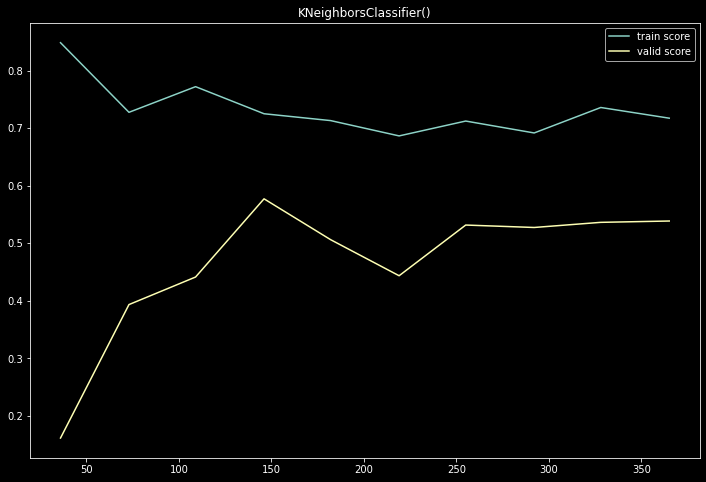

In [5]:
for modil in model_list:
    model_evaluation(modil)

In [6]:
#One must look at all taken models and from now on work on hyperparameters to get better results
for i in range(len(model_list)):
    observe_params(model_list[i])

AdaBoostClassifier(random_state=0) 
dict_keys(['memory', 'steps', 'verbose', 'pipeline', 'adaboostclassifier', 'pipeline__memory', 'pipeline__steps', 'pipeline__verbose', 'pipeline__polynomialfeatures', 'pipeline__selectkbest', 'pipeline__polynomialfeatures__degree', 'pipeline__polynomialfeatures__include_bias', 'pipeline__polynomialfeatures__interaction_only', 'pipeline__polynomialfeatures__order', 'pipeline__selectkbest__k', 'pipeline__selectkbest__score_func', 'adaboostclassifier__algorithm', 'adaboostclassifier__base_estimator', 'adaboostclassifier__learning_rate', 'adaboostclassifier__n_estimators', 'adaboostclassifier__random_state'])
__________________________________________________________________________________________
RandomForestClassifier(random_state=0) 
dict_keys(['memory', 'steps', 'verbose', 'pipeline', 'randomforestclassifier', 'pipeline__memory', 'pipeline__steps', 'pipeline__verbose', 'pipeline__polynomialfeatures', 'pipeline__selectkbest', 'pipeline__polynomialfea

In [38]:
svc_params = {'svc__gamma': [1e-3, 1e-4],
              'svc__C': [1, 10, 100, 1000]}
ada_params = {'adaboostclassifier__base_estimator': [DecisionTreeClassifier, 
                                                     RandomForestClassifier(random_state=0)],
              'adaboostclassifier__learning_rate': [1, 5, 10, 100],
              'adaboostclassifier__n_estimators': [10, 50, 100, 200]}
knn_params = {'kneighborsclassifier__n_neighbors': np.arange(1, 21),
              'kneighborsclassifier__metric': ['euclidean', 'manhattan']}
rf_params = {'randomforestclassifier__min_samples_split': np.arange(1, 6),
             'randomforestclassifier__n_estimators': [10, 100, 500]}

______________________________________________________________________
{'svc__C': 1000, 'svc__gamma': 0.001}
Test set total patient number: 111
Positive cases: 95, predicted: 92 true positives and 3 false positives
Positive cases: 16, predicted: 9 false negatives and 7 true negatives
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        95
           1       0.70      0.44      0.54        16

    accuracy                           0.89       111
   macro avg       0.81      0.70      0.74       111
weighted avg       0.88      0.89      0.88       111



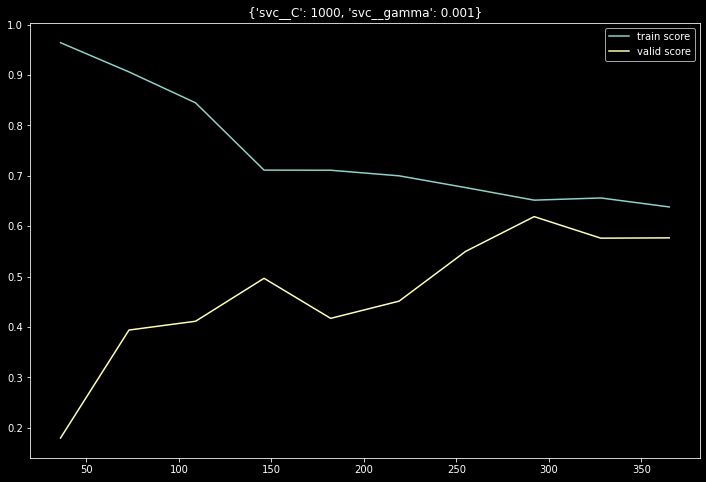

In [40]:
from sklearn.model_selection import GridSearchCV #RandomizedSearchCV

grid_svc = GridSearchCV(model_svm, svc_params, scoring='recall', cv=5)
grid_knn = GridSearchCV(model_knn, knn_params, scoring='recall', cv=5)
grid_rf = GridSearchCV(model_rf, rf_params, scoring='recall', cv=5)
grid_ada = GridSearchCV(model_ada, ada_params, scoring='recall', cv=5)
grid_evaluation(grid_svc)

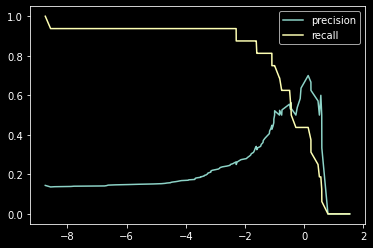

In [35]:
from sklearn.metrics import precision_recall_curve, recall_score

grid_svc.fit(X_train, y_train)
precision, recall, thresholds = precision_recall_curve(y_test, grid_svc.best_estimator_.decision_function(X_test))
plt.plot(thresholds, precision[:-1], label='precision')
plt.plot(thresholds, recall[:-1], label='recall')
plt.legend()

In [36]:
def final_model(model, X, threshold=0):
    return model.decision_function(X) > threshold

y_pred_final = final_model(grid_svc.best_estimator_, X_test, threshold= -0.5) #threshold value is observed in the plot above
f1_score(y_test, y_pred_final)
recall_score(y_test, y_pred_final)

0.625

In [41]:
#GLOBAL CONCLUSION
#for this test, different models were tried and the one that was pushed till the end has a recall for positive detected person of 0.97
#however, at the end of covid_modeling we see that the recall score of our SVC model is 0.625, which is pretty good level, 
#taking into account the poverty of our initial dataframe(high number of NaN values, low accuracy, 'Patient age quantile' definition', the source of our dataframe...)

#N.B. THIS IS NOT THE FINAL MODEL 
#we could eventually continue evaluating models varying the hyperparameter quantity and their content.